# Preparing the dataset for hippocampus segmentation

In this notebook you will use the skills and methods that we have talked about during our EDA Lesson to prepare the hippocampus dataset using Python. Follow the Notebook, writing snippets of code where directed so using Task comments, similar to the one below, which expects you to put the proper imports in place. Write your code directly in the cell with TASK comment. Feel free to add cells as you see fit, but please make sure that code that performs that tasked activity sits in the same cell as the Task comment.


In [1]:
# TASK: Import the following libraries that we will use: nibabel, matplotlib, numpy
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import re
import pandas as pd
import seaborn as sns
import shutil

It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/). I will refer to Slicer throughout this Notebook and will be pasting some images showing what your output might look like.

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found here: https://nipy.org/nibabel/

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [2]:
# TASK: Your data sits in directory /data/TrainingSet.
# Load an image and a segmentation mask into variables called image and label

# Directory where we have the data and the first filename
# datadir = '/data/TrainingSet'
datadir = 'data/TrainingSet'
filename = 'hippocampus_003.nii.gz'

# Set global variables that aren't going to change
IM_PATH = os.path.join(os.path.abspath(''), datadir, 'images')
LB_PATH = os.path.join(os.path.abspath(''), datadir, 'labels')

# Load both as nifty files
image = nib.load(os.path.join(IM_PATH, filename))
label = nib.load(os.path.join(LB_PATH, filename))

In [3]:
# Also I get all the paths of the images and labels. I get them sorted to be able to check
# any difference in names

# Get absolute paths with the specified format
# images_paths = sorted(glob(os.path.join(IM_PATH, '*.nii.gz')))
# labels_paths = sorted(glob(os.path.join(LB_PATH, '*.nii.gz')))

In [4]:
# Get image filenames with given regular expression
images_names = sorted([[file for file in files if re.match('^hippocampus_\d{3}.nii.gz$', file)] for _, _, files in os.walk(IM_PATH)][0])

# Get label filenames that correspond to that image filenames
labels_names = sorted([[file for file in files if file in images_names] for dirs, subdirs, files in os.walk(LB_PATH)][0])

# Show some examples of names
print(images_names[:4])
print(labels_names[:4])

['hippocampus_001.nii.gz', 'hippocampus_003.nii.gz', 'hippocampus_004.nii.gz', 'hippocampus_006.nii.gz']
['hippocampus_001.nii.gz', 'hippocampus_003.nii.gz', 'hippocampus_004.nii.gz', 'hippocampus_006.nii.gz']


In [5]:
# Check that we have same number of images and labels. Look out!!
print(len(images_names))
print(len(labels_names))

263
262


In [6]:
# Since we have one more image than labels, it's necessary to find out
# which is the image without label and discard it. To do this, I'll loop through all
# image names and compare them with label names.
for i_n in images_names:   
    # If this filename is not in labels...
    if i_n not in labels_names:
        # Remove filename and log it
        images_names.remove(i_n)
        print("Removed file {} from list because there's no label for it".format(i_n))

Removed file hippocampus_118.nii.gz from list because there's no label for it


In [7]:
# Check that we have same number of images and labels.
print(len(images_names))
print(len(labels_names))

262
262


In [8]:
# Nibabel can present your image data as a Numpy array by calling the method get_fdata()
# The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities. 
# In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?

# See that image and label has same dimensions. This is a check that could be done with all of the images and labels
print(image.get_fdata().shape)
print(label.get_fdata().shape)

(34, 52, 35)
(34, 52, 35)


In [9]:
# Apply same check to the entire dataset, and also I take advantadge of this loop to get
# some interesting data and store them in a dataframe.

def nifti_check(filenames, image_path, label_path):
    # To apply this function it is necessary that you have same number of images and labels, and same filenames.
    
    c = ['Name', '#1D', '#2D', '#3D', 'ImageVol', 'BitPix', 'Units', 'PixDim', 'MarkedVol']
    df = pd.DataFrame([], columns=c)
    ix = 0
    
    errors_dim = False
    errors_soh = False
    errors_hcl = False

    for name in filenames:
        insert = True

        # Load image and label
        im = nib.load(os.path.join(image_path, name))
        lb = nib.load(os.path.join(label_path, name))

        # Get dimensions
        # Dimensions can be obtained with:
        #    tuple(image.header['dim'][1:4])
        # or
        #    image.get_fdata().shape
        # with identical results
        i1, i2, i3 = im.get_fdata().shape
        l1, l2, l3 = lb.get_fdata().shape

        # Check dimensions' consistency.
        # Image and labels should have same dimensions
        if not((i1==l1) & (i2==l2) & (i3==l3)):
            insert = False
            errors_dim = True
            print('Error in shapes. Name: {} - Image shape: {} - Label shape: {}'. format(name, im.get_fdata().shape, lb.get_fdata().shape))

        # Size of header. It must be 348 for NIFTI. Image and label should have same value.
        soh = im.header.sizeof_hdr
        if (lb.header.sizeof_hdr != soh) | (soh != 348):
            insert = False
            errors_soh = True
            print('Error in size of header. Name: {} - Size image header: {} - Size label header: {}'. format(name, soh, lb.header.sizeof_hdr))

        # Header class. Image and label should have the same header class
        hcl = im.header_class
        if str(hcl) != "<class 'nibabel.nifti1.Nifti1Header'>":
            insert = False
            errors_hcl = True
            print('Error in header class. Name: {} - Image header: {} - Label header: {}'. format(name, hcl, lb.header_class))

        if insert:
            # Bitpix. Number of bits per voxel
            bp = im.header['bitpix']
            
            # Units. Units of X, Y and Z dimensions
            units = im.header.get_xyzt_units()[0]
            
            # Voxel dimensions. Magnitude of X, Y and Z in units specified in 'units'
            pixdim = tuple(im.header['pixdim'][1:4])
            
            # Marked vol. Number of voxels with value higher than 0 in the mask
            mvol = np.count_nonzero(lb.get_fdata())

            row = pd.Series({c[0]: name, c[1]: i1, c[2]: i2, c[3]: i3, c[4]: i1*i2*i3,
                             c[5]: bp, c[6]: units, c[7]: pixdim, c[8]: mvol}, name=ix)
            # df = df.append(row)
            # row = pd.DataFrame({c[0]: name, c[1]: i1, c[2]: i2, c[3]: i3, c[4]: i1*i2*i3,
            #                   c[5]: bp, c[6]: units, c[7]: pixdim, c[8]: mvol})
            # df = pd.concat([df, row], axis=0)
            df.loc[ix] = row
            ix += 1
    
        #if ix == 5: break
    
    if not errors_dim: print('All dimensions consistency checked and ok')
    if not errors_soh: print('All sizes of headers checked and ok')
    if not errors_hcl: print('All headers classes checked and ok')
    
    return df

# Apply checks and generate the dataframe
df = nifti_check(images_names, IM_PATH, LB_PATH)
df.head()

Error in shapes. Name: hippocampus_010.nii.gz - Image shape: (512, 512, 241) - Label shape: (36, 50, 31)
Error in shapes. Name: hippocampus_281.nii.gz - Image shape: (512, 512, 31) - Label shape: (512, 512, 94)
All sizes of headers checked and ok
All headers classes checked and ok


,Name,#1D,#2D,#3D,ImageVol,BitPix,Units,PixDim,MarkedVol
0,hippocampus_001.nii.gz,35,51,35,62475,8,mm,"(1.0, 1.0, 1.0)",2948
1,hippocampus_003.nii.gz,34,52,35,61880,32,mm,"(1.0, 1.0, 1.0)",3353
2,hippocampus_004.nii.gz,36,52,38,71136,32,mm,"(1.0, 1.0, 1.0)",3698
3,hippocampus_006.nii.gz,35,52,34,61880,32,mm,"(1.0, 1.0, 1.0)",4263
4,hippocampus_007.nii.gz,34,47,40,63920,32,mm,"(1.0, 1.0, 1.0)",3372


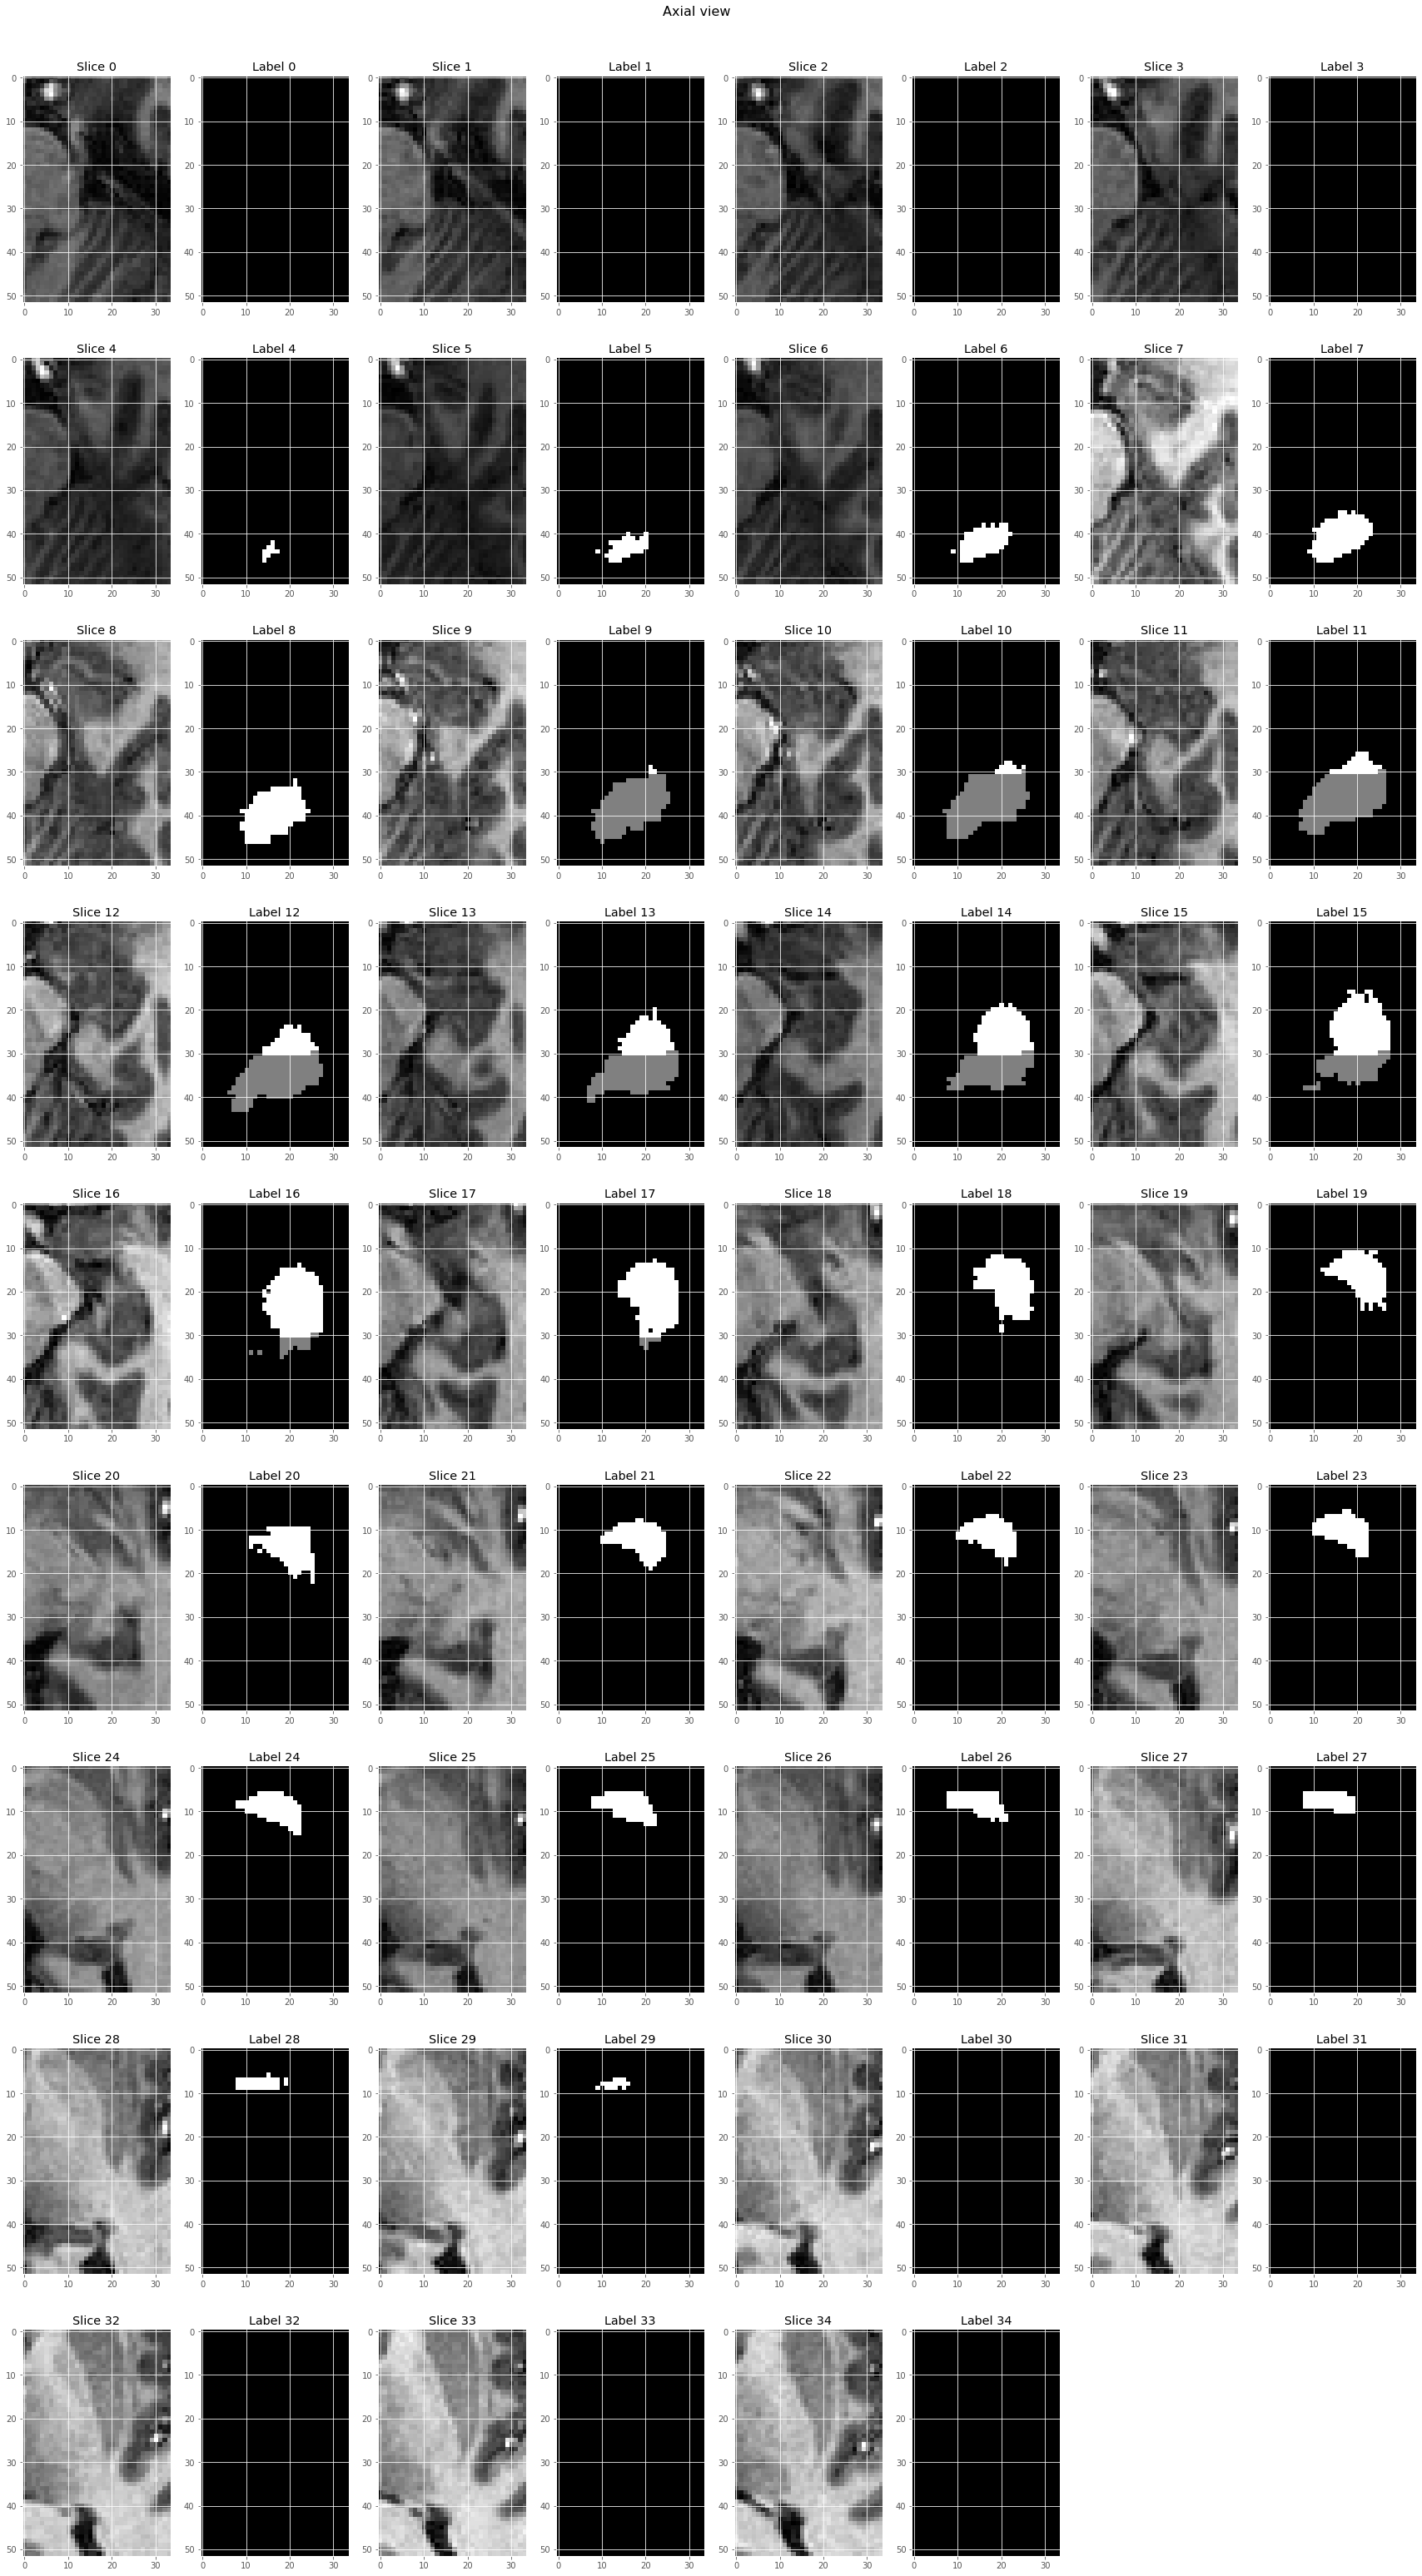

In [10]:
# TASK: using matplotlib, visualize a few slices from the dataset, along with their labels. 
# You can adjust plot sizes like so if you find them too small:
# plt.rcParams["figure.figsize"] = (10,10)

image_data = image.get_fdata()
label_data = label.get_fdata()

# Dimensions are ordered as: [Sagittal, Coronal, Axial]
# Axial views (loop through image.get_fdata().shape[2])
n_slices = image.get_fdata().shape[2]
n_rows = np.ceil(n_slices / 4)

plt.style.use("ggplot")
plt.figure(figsize=(30, 55))
plt.suptitle('Axial view', x=0.5, y=0.9, fontsize=16)
for ix in np.arange(0, n_slices):
    plt.subplot(n_rows, 8, 1 + 2*ix)
    plt.imshow(np.fliplr(np.rot90(image_data[:, :, ix])), cmap='gray')
    plt.title("Slice {}".format(ix))
    plt.subplot(n_rows, 8, 2 + 2*ix)
    plt.imshow(np.flip(np.rot90(label_data[:, :, ix])), cmap='gray')
    plt.title("Label {}".format(ix))

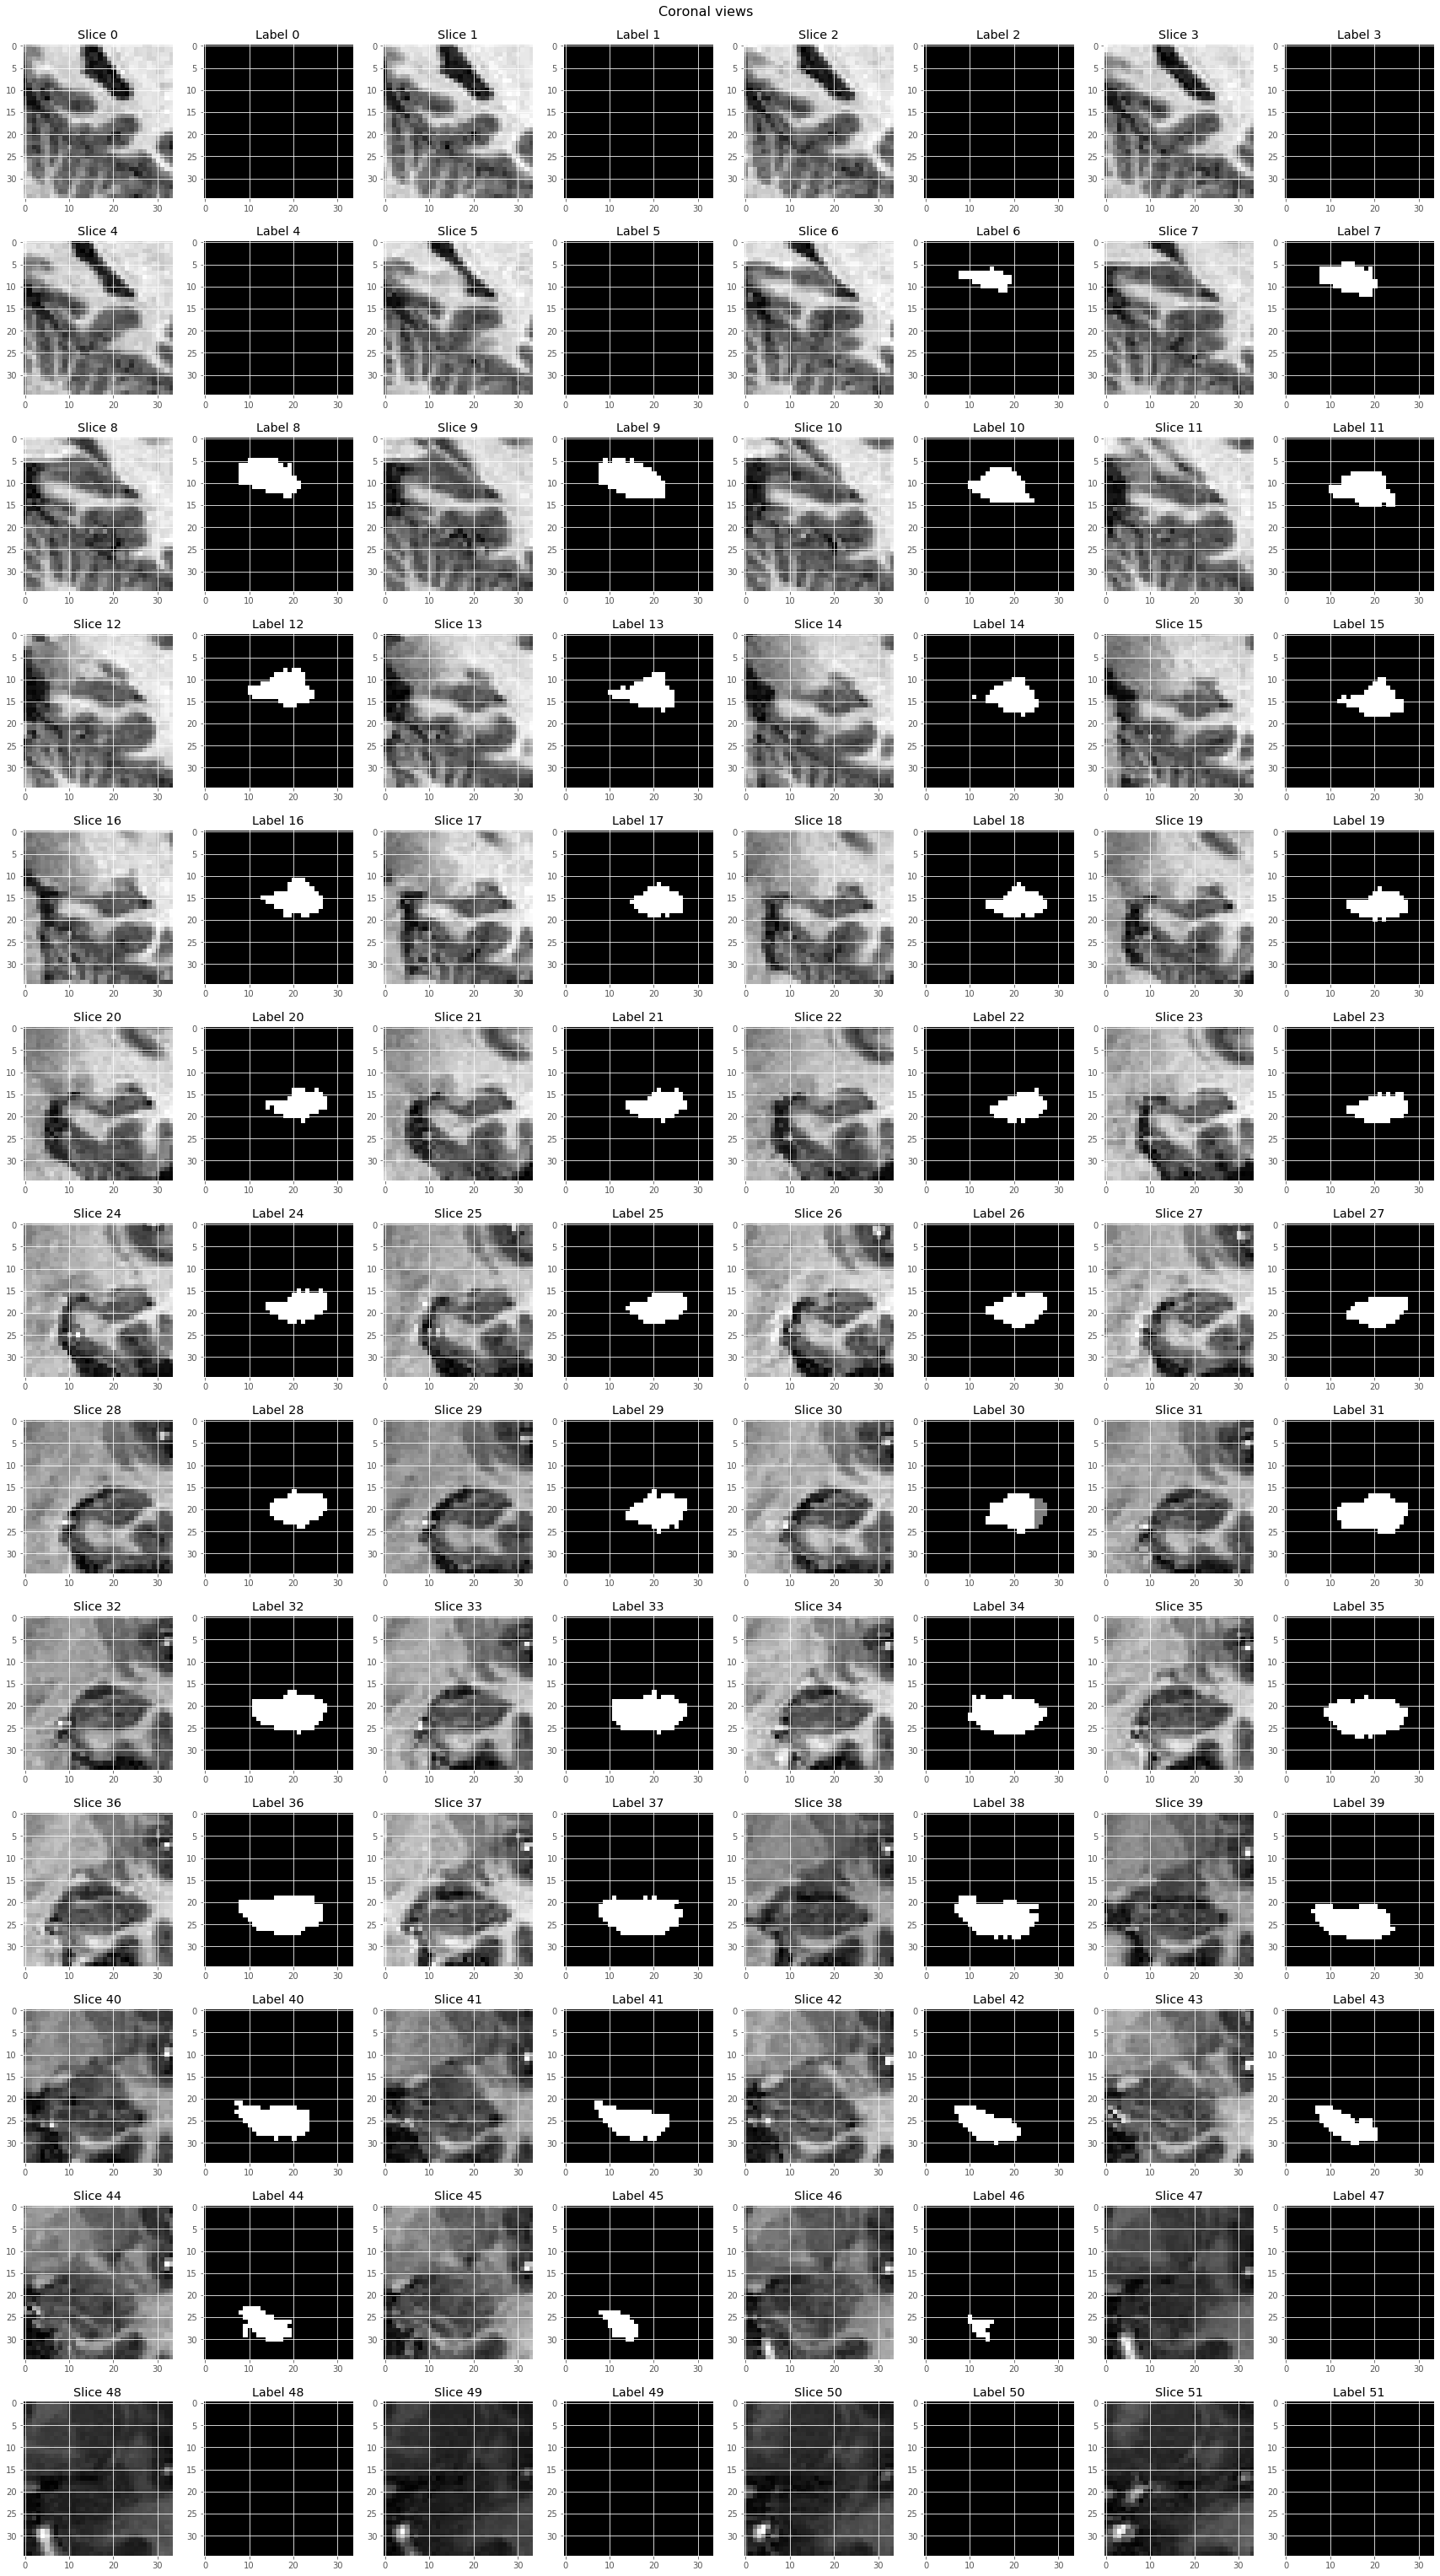

In [11]:
# Coronal views (loop through image.get_fdata().shape[1])
# Dimensions are ordered as: [Sagittal, Coronal, Axial]
n_slices = image.get_fdata().shape[1]
n_rows = np.ceil(n_slices / 4)

plt.style.use("ggplot")
plt.figure(figsize=(30, 55))
plt.suptitle('Coronal views', x=0.5, y=0.89, fontsize=16)
for ix in np.arange(0, n_slices):
    plt.subplot(n_rows, 8, 1 + 2*ix)
    plt.imshow(np.fliplr(np.rot90(image_data[:, ix, :])), cmap='gray')
    plt.title("Slice {}".format(ix))
    plt.subplot(n_rows, 8, 2 + 2*ix)
    plt.imshow(np.fliplr(np.rot90(label_data[:, ix, :])), cmap='gray')
    plt.title("Label {}".format(ix))
    #if ix == 19: break

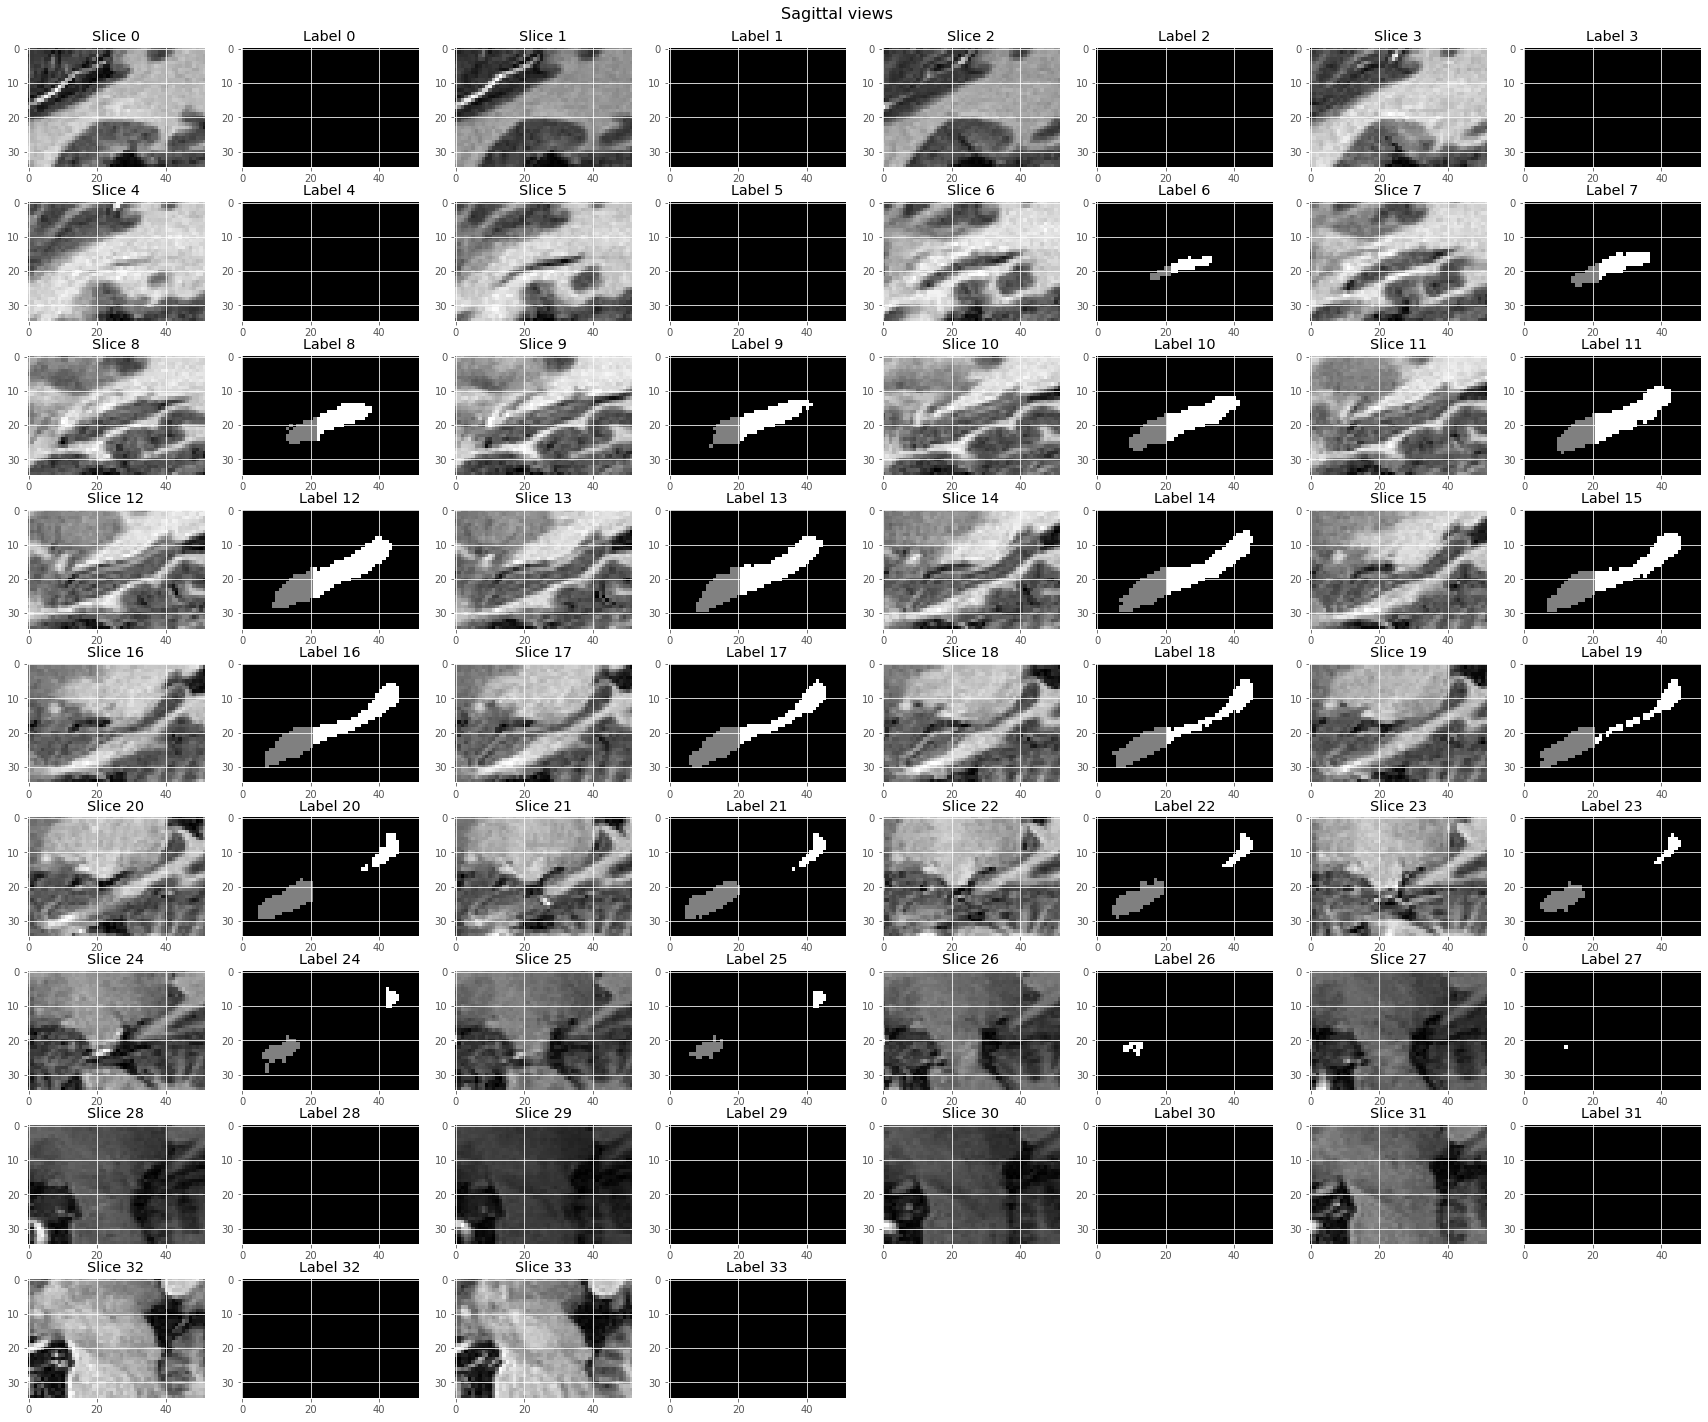

In [12]:
# Sagittal views (loop through image.get_fdata().shape[0])
# Dimensions are ordered as: [Sagittal, Coronal, Axial]
n_slices = image.get_fdata().shape[0]
n_rows = np.ceil(n_slices / 4)

plt.style.use("ggplot")
plt.figure(figsize=(30, 25))
plt.suptitle('Sagittal views', x=0.5, y=0.9, fontsize=16)
for ix in np.arange(0, n_slices):
    plt.subplot(n_rows, 8, 1 + 2*ix)
    plt.imshow(np.fliplr(np.rot90(image_data[ix, :, :])), cmap='gray')
    plt.title("Slice {}".format(ix))
    plt.subplot(n_rows, 8, 2 + 2*ix)
    plt.imshow(np.fliplr(np.rot90(label_data[ix, :, :])), cmap='gray')
    plt.title("Label {}".format(ix))
    # if ix == 19: break

Load volume into 3D Slicer to validate that your visualization is correct and get a feel for the shape of structures.

Visualization of slices Sagittal=20, Coronal=26, Axial=19 in 3D Slicer with mask on top of it, and volume rendered.
<img src="img/3D_slice_03.png" width=1000 align=center>

Visualization of slices Sagittal=20, Coronal=26, Axial=19 in 3D Slicer without mask, and volume rendered.
<img src="img/3D_slice_04.png" width=1000 align=center>

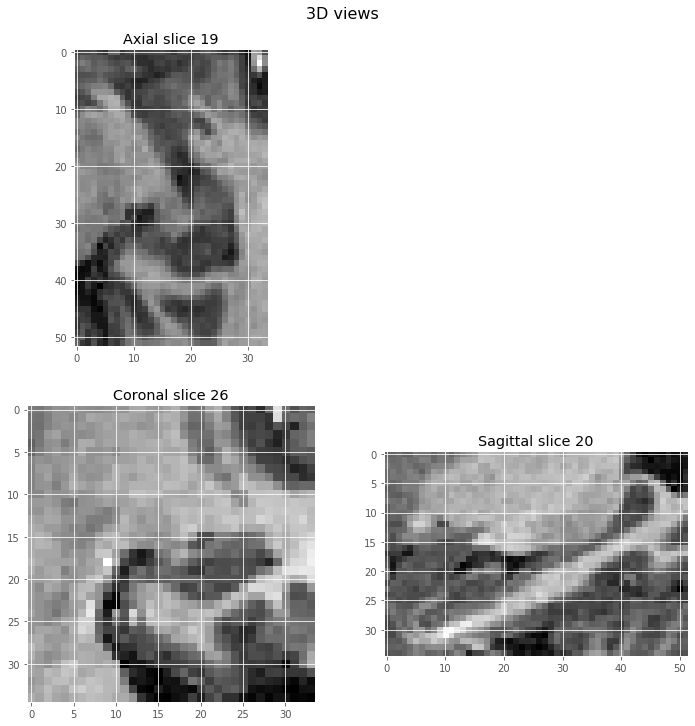

In [13]:
# Check views with the ones seen in 3D slicer
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.suptitle('3D views', x=0.5, y=0.93, fontsize=16)

plt.subplot(2, 2, 1)
plt.imshow(np.fliplr(np.rot90(image_data[:, :, 19-1])), cmap='gray')
plt.title("Axial slice 19")
plt.subplot(2, 2, 3)
plt.imshow(np.fliplr(np.rot90(image_data[:, 26-1, :])), cmap='gray')
plt.title("Coronal slice 26")
plt.subplot(2, 2, 4)
plt.imshow(np.fliplr(np.rot90(image_data[20-1, :, :])), cmap='gray')
plt.title("Sagittal slice 20");

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [14]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images 
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?

# These tasks have already been done in the nifti_check function for all of the images and labels.

# Next we can see an example of what's been done before with the header class
print('Header class of image: {}'.format(image.header_class))
if str(image.header_class) == "<class 'nibabel.nifti1.Nifti1Header'>":
    print('This is a nifti header')
else:
    print('LOOK OUT!! This is NOT a nifti header')

Header class of image: <class 'nibabel.nifti1.Nifti1Header'>
This is a nifti header


Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [15]:
# TASK: How many bits per pixel are used?

# We have two different values, 8 bit and 32 bit
print(list(np.unique(df['BitPix'])))

[array(8, dtype=int16), array(32, dtype=int16)]


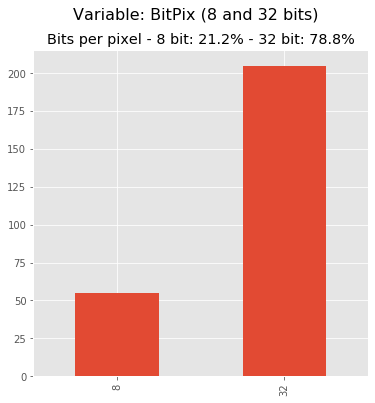

In [16]:
# In the next plot we can see the number of times of each case, and
# the percentage in the entire dataset

plt.style.use("ggplot")
plt.figure(figsize=(6, 6))
plt.suptitle('Variable: BitPix (8 and 32 bits)', fontsize=16)

df['BitPix'].value_counts().sort_index().plot(kind='bar');
_ = plt.title('Bits per pixel - 8 bit: {:.1f}% - 32 bit: {:.1f}%'.format(
    100*len(df[df['BitPix']==8])/len(df), 100*len(df[df['BitPix']==32])/len(df)))

In [17]:
# TASK: What are the units of measurement?

# All units are milimeters, as seen in the next command
print(np.unique(df['Units']))

# So once known, we can drop the column
df = df.drop('Units', axis=1)

['mm']


In [18]:
# TASK: Do we have a regular grid? What are grid spacings?

# Yes, we have a regular grid, as can be seen in the next command, where we can
# see that all files have the value 1.0 in the positions 1, 2 and 3 of the 
# PixDim array (data collected before in the nifti_check function)
print('The percentage of PixDim with length values equals to (1,1,1) is {:.1f}%'.format(
    100*len(df[df['PixDim'] == (1.0, 1.0, 1.0)]) / len(df)))


The percentage of PixDim with length values equals to (1,1,1) is 100.0%


In [19]:
# TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?

# Dimensions are ordered as: [Sagittal, Coronal, Axial]

# Dimensions can be obtained from the header info:
print(tuple(image.header['dim'][1:4]))
# or directly from the numpy array shape
print(image.get_fdata().shape)
# with identical results

(34, 52, 35)
(34, 52, 35)


The dimensions can be obtained of the field _header['dim']_ or directly from the shape of the numpy-array. The field _header['dim']_ is an array of 8 values, being the positions from one to four those that correspond to the dimensions x, y and z respectively, as stated [here](https://brainder.org/2012/09/23/the-nifti-file-format/)

```
Image dimensions

The field short dim[8] contains the size of the image array. The first element (dim[0]) contains the number of dimensions (1-7). If dim[0] is not in this interval, the data is assumed to have opposite endianness and so, should be byte-swapped (the nifti standard does not specify a specific field for endianness, but encourages the use of dim[0] for this purpose). The dimensions 1, 2 and 3 are assumed to refer to space (x, y, z), the 4th dimension is assumed to refer to time, and the remaining dimensions, 5, 6 and 7, can be anything else. The value dim[i] is a positive integer representing the length of the i-th dimension.
```

So, since nifti is a left-handed coordinate system, and z axis is axial, the coordinate systems is as follows.
<img src="img/Coordinates.png" width=600 align=center>



In [20]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
# You should get a number between ~2200 and ~4500

# All the mask values have been stored in the column 'MarkedVol' of the dataframe.
# Since x, y, z are in milimeters and equals to 1, each voxel has a volumne of 1mm³
print('The volume of the current mask is {} mm³'.format(np.count_nonzero(label.get_fdata())))

The volume of the current mask is 3353 mm³


## Plotting some charts

In [21]:
len(np.unique(df['MarkedVol']))

240

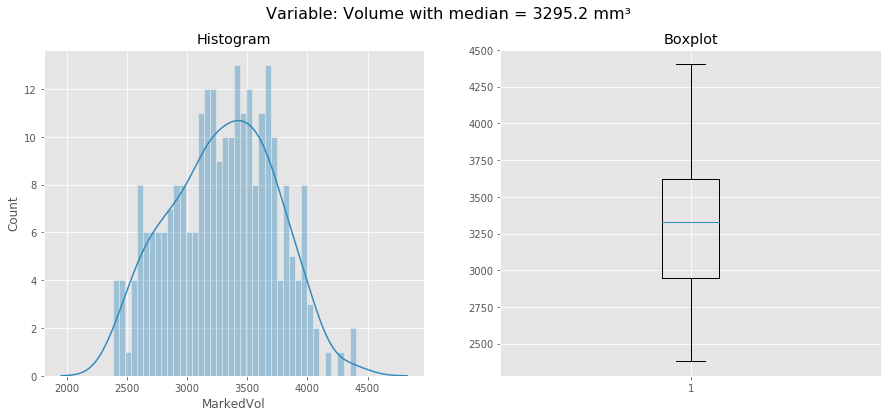

In [30]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.

m = np.mean(df['MarkedVol'])

plt.style.use("ggplot")
plt.figure(figsize=(15, 6))
plt.suptitle('Variable: Volume with median = {:.1f} mm³'.format(m), fontsize=16)

# Subplot 1 - Histogram
plt.subplot(121)
# sns.distplot(df['MarkedVol'])
sns.histplot(df['MarkedVol'].astype(float), bins=40, alpha=0.4, kde=True, kde_kws={"cut": 3})
plt.title('Histogram');

# Subplot 2 - Boxplot
plt.subplot(122)
plt.boxplot(df['MarkedVol'])
plt.title('Boxplot');

As we can see, our population has a median of 3295 mm³. This value is approximately the 10th percentile of the general population, so probably our population is affected by Alzheimer Disease and its correspondig volume reduction of the hippocampus.

<img src="img/nomogram_fem_right.svg" width=400 align=left>

Do you see any outliers? Why do you think it's so (might be not immediately obvious, but it's always a good idea to inspect) outliers closer. If you haven't found the images that do not belong, the histogram may help you.

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. 

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

In [28]:
# TASK: Copy the clean dataset to the output folder inside section1/out. You will use it in the next Section

# Create folders if they don't exist
if not os.path.exists("out/images"):
    os.makedirs("out/images")

if not os.path.exists("out/labels"):
    os.makedirs("out/labels")

ix = 0
for name in df['Name']:
    # Get paths and copy image
    im_origin = os.path.join(IM_PATH, name)
    im_dest = os.path.join(os.path.abspath(''), "out/images/", name)
    shutil.copy(im_origin, im_dest)
    
    # Get path and copy label
    lb_origin = os.path.join(LB_PATH, name)
    lb_dest = os.path.join(os.path.abspath(''), "out/labels/", name)
    shutil.copy(lb_origin, lb_dest)
    
    # Control for test
#     ix += 1
#     if ix == 2: break

## Final remarks

Congratulations! You have finished Section 1. 

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!